In [1]:
import pandas as pd
import numpy as np
import sys
from rdkit import Chem
from rdkit.Chem import Draw

import matplotlib as mlp
mlp.rcParams['lines.linewidth'] = 2
mlp.rcParams['axes.grid'] = True
mlp.rcParams['grid.linestyle'] = '--'
mlp.rcParams['xtick.labelsize'] = 12
mlp.rcParams['ytick.labelsize'] = 12
mlp.rcParams['axes.labelsize'] = 14
mlp.rcParams['legend.fontsize'] = 12
mlp.rcParams['font.size'] = 12
mlp.rcParams['font.family'] = 'serif'
mlp.rcParams['mathtext.fontset'] = 'dejavuserif'

# Import Virtuous Library

Include the Virtuous.py library into your PYTHONPATH to be able to import the module directly 

In [2]:
# import Virtuous Library
sys.path.append('../scripts/')
import Virtuous
Virtuous.__version__

[00:33:24] Initializing Normalizer


'1.8'

# 1. Processing a single molecule

## 1.1 Defining the SMILES to be processed

The user of the Virtuous platform will submit this type of representation for the molecule of interest

In [3]:
smi = "C(CC(=O)[O-])C(C(=O)[O-])[NH3+]" 

## 1.2 Import SMILES as molecule object

The *Virtuous.ReadMol* function reads different types of molecule formats (SMILES [default], FASTA, Inchi, PDB, Sequence, Smarts) and will create the relative molecule object using RDKit

In [4]:
mol = Virtuous.ReadMol(smi, verbose=True)

Input has been interpeted as SMILES


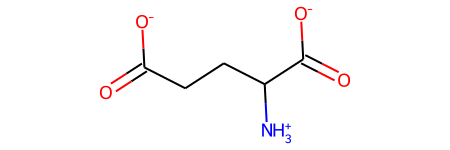

In [5]:
mol

## 1.3 Standardise molecule with the ChEMBL structure pipeline 
https://github.com/chembl/ChEMBL_Structure_Pipeline)

The pipeline processes the query molecule with three steps: 
1) *Checker*: identifies and validates structures and identifies problems before they are added to the database
2) *Standardizer*: processes (standardises) chemical structures according to a set of predefined rules
3) *GetParent*: generates parent structures based on a set of rules and defined lists of salts and solvents

In [6]:
issues, std_smi, parent_smi = Virtuous.Standardize (mol)

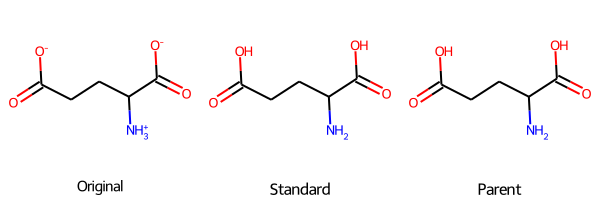

In [7]:
mols = [mol, Virtuous.ReadMol(std_smi,  verbose=False), Virtuous.ReadMol(parent_smi, verbose=False)]
img=Chem.Draw.MolsToGridImage(mols,molsPerRow=3,subImgSize=(200,200),legends=["Original", "Standard", "Parent"] ) 
img

- **issues** contains a score from the *Checker* tool: score greater than 5 denote compounds with severe structural problems
- **std_smi** contains the STANDARD SMILES generated by the *Standardizer* tool
- **parent_smi** is the parent SMILES obtained using the *GetParent* tool

The parent SMILES will be used for the subsequent featurization, i.e. the calculation of descriptors

***NOTE***: if the issues is greater than 5 the query molecule should not be processed further and the user might consider to re-check it.

## 1.4 Check the Applicability Domain (AD)

The Virtuous.TestAD check if the query compound in inside the Umami Applicability Domain defined during the model implementation: this analysis gives a measure of the reliability of the taste prediction, since only compounds similar to the employed umami/non-umami dataset can be effectively classified.

You can set the verbose parameter: if True, a message with the result of the AD check will appears; if False, silent mode. Parameter of the function have been optimized during the implementation of the Umami predictor.

In [8]:
AD_file = "../data/bittersweet_AD_train.pkl"

In [9]:
test, score, sim_smiles = Virtuous.TestAD(parent_smi, filename=AD_file, verbose = True, sim_threshold=0.21, neighbors = 5, metric = "tanimoto")

OK: The query compound is inside the Applicability Domain!


**If the molecule is outside the AD of the model, the user is warned but the classification will be performed anyway**

You can represent the 5 most similar compounds in the umami dataset 

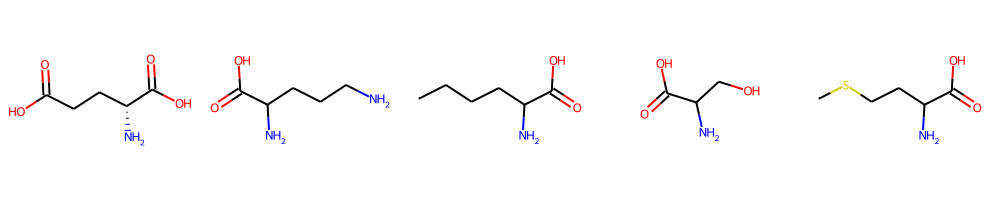

In [10]:
mols = [Virtuous.ReadMol(smi, verbose=False) for smi in sim_smiles]
img=Chem.Draw.MolsToGridImage(mols,molsPerRow=5,subImgSize=(200,200))#,legends=sim_smiles) 
img

You can also represent the similarity map of the query compound with respect to the most similar compound in the ummai

In [11]:
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem, DataStructs

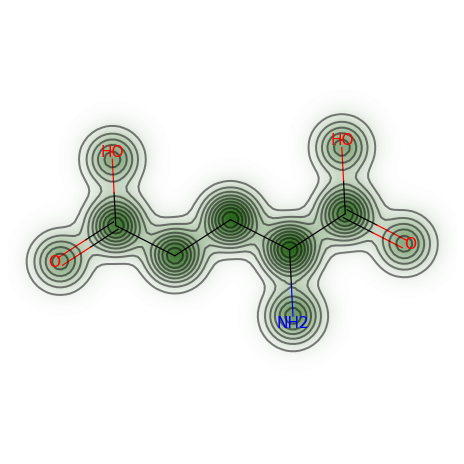

In [12]:
fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(mols[0], Virtuous.ReadMol(parent_smi, verbose=False), SimilarityMaps.GetMorganFingerprint, metric=DataStructs.TanimotoSimilarity)

## 1.5 Featurization: Calculation of the molecular descriptors

The Virtuous.CalcDesc function will calculate a set of molecualar descriptors using different methods: 
1) **Mordred**: 1826 descriptors -> https://mordred-descriptor.github.io/documentation/master/descriptors.html
2) **RDKit**:   208 descriptors
3) **pybel**:    25 descriptors

*The user can select which descriptors wants to calculate setting to True/False the relative variable in the function (by default all descriptors will be calculated).*

*Here we calculate all descriptors since the VirtuousSweetBitter Model was realized considering all of them*

In [13]:
DescNames, DescValues = Virtuous.CalcDesc(parent_smi, Mordred=True, RDKit=True, pybel=True)

In [14]:
# visualising with pandas
sample_df = pd.DataFrame(data = np.array(DescValues).reshape(-1, len(DescValues)), columns=DescNames)
sample_df.insert(loc=0, column='SMILES', value=parent_smi)
sample_df = sample_df.loc[:,~sample_df.columns.duplicated()]
sample_df

,SMILES,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,...,L5,logP,MP,MR,rotors,s,sbonds,smarts,tbonds,title
0,NC(CCC(=O)O)C(=O)O,6.87047,7.091508,2.0,1.0,10.915687,2.106723,4.213447,10.915687,1.091569,...,NaN,-0.0366,182.6672,32.4,4.0,NaN,7.0,NaN,0.0,NaN


In [15]:
# if you want to save the descriptors in a csv file, uncomment the following line
#sample_df.to_csv("descriptors.csv", index=False)

## 1.6 Run the model to predict Sweet/Bitter taste

The Virtuous.PredictExplain function will calculate the Sweet/Bitter prediction with associated probability and show a SHAP local explanation plot.

*SHAP values are shown in the left panel and impacting feature distributions in the right panel, with values assumed by the features highlighted with solid red lines.*

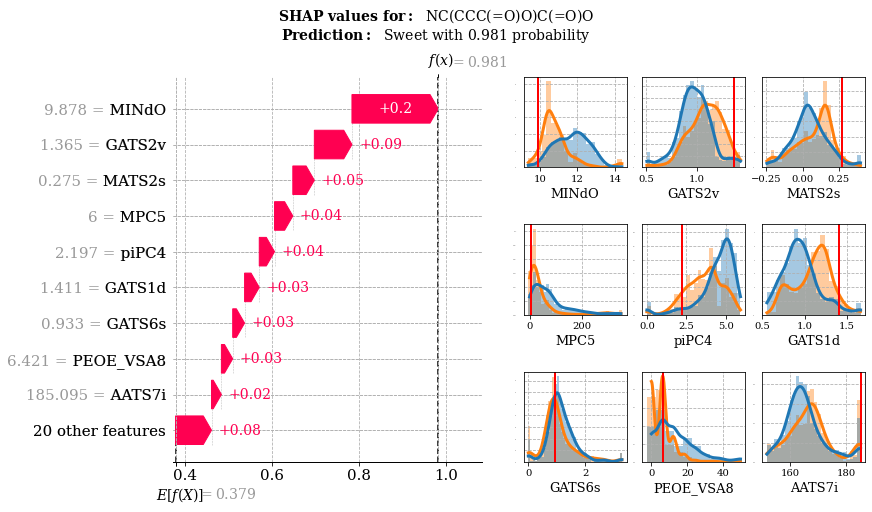

In [16]:
Virtuous.PredictExplain(sample_df)